<a href="https://colab.research.google.com/github/varmagsr/Classify-Recipes-based-on-Ingredients/blob/main/Classify_Recipes_based_on_Ingredients.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from tqdm import tqdm
#import skillsnetwork
import json
import scipy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import io
import requests

In [3]:
%matplotlib inline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.metrics import accuracy_score

In [4]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

In [8]:
data_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-PY0181EN-SkillsNetwork/labs/2_linear_classifiers/data/data.json"
data = json.loads(requests.get(data_url).text)

# Flattening JSON data
recipes = pd.json_normalize(data)

In [9]:
recipes.shape

(39774, 3)

In [10]:
recipes.head()

,id,cuisine,ingredients
0,10259,greek,"[romaine lettuce, black olives, grape tomatoes..."
1,25693,southern_us,"[plain flour, ground pepper, salt, tomatoes, g..."
2,20130,filipino,"[eggs, pepper, salt, mayonaise, cooking oil, g..."
3,22213,indian,"[water, vegetable oil, wheat, salt]"
4,13162,indian,"[black pepper, shallots, cornflour, cayenne pe..."


In [13]:
recipes.sample(5)

,id,cuisine,ingredients
36056,32999,chinese,"[dark soy sauce, sesame oil, whole chicken, sh..."
4292,2874,italian,"[cremini mushrooms, unsalted butter, veal shan..."
25368,15962,italian,"[butter, arugula, bread slices, rocket leaves,..."
34310,20656,thai,"[salt, galangal, fish sauce, coconut milk, kaf..."
39631,1782,southern_us,"[milk, vegetable oil, large eggs, all-purpose ..."


In [14]:
recipes["cuisine"].unique().tolist()

['greek',
 'southern_us',
 'filipino',
 'indian',
 'jamaican',
 'spanish',
 'italian',
 'mexican',
 'chinese',
 'british',
 'thai',
 'vietnamese',
 'cajun_creole',
 'brazilian',
 'french',
 'japanese',
 'irish',
 'korean',
 'moroccan',
 'russian']

In [15]:
len(recipes["cuisine"].unique())

20

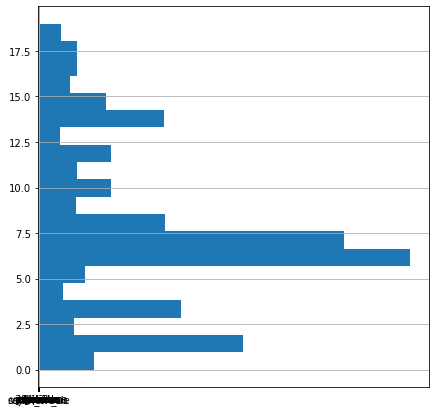

In [16]:
recipes["cuisine"].hist(orientation='horizontal', bins=20, figsize=(7,7))

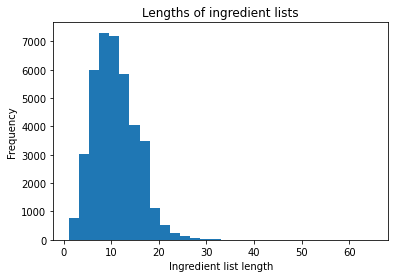

In [18]:
plt.hist(recipes['ingredients'].apply(lambda x: len(x)), bins = 30)
plt.title("Lengths of ingredient lists")
plt.xlabel("Ingredient list length")
plt.ylabel("Frequency")
plt.show()

In [19]:
all_ingredients = recipes['ingredients'].explode()
all_ingredients

0        romaine lettuce
0           black olives
0         grape tomatoes
0                 garlic
0                 pepper
              ...       
39773             garlic
39773        white sugar
39773      roma tomatoes
39773             celery
39773      dried oregano
Name: ingredients, Length: 428275, dtype: object

In [20]:
ingredients = all_ingredients.unique()
len(ingredients)

6714

In [22]:
# Inggredients from the first dish in training data
recipes.loc[0,'ingredients']

['romaine lettuce',
 'black olives',
 'grape tomatoes',
 'garlic',
 'pepper',
 'purple onion',
 'seasoning',
 'garbanzo beans',
 'feta cheese crumbles']

In [24]:
# Converted the list into one string
recipes['ingredients'].astype(str)[0].strip('[]')

"'romaine lettuce', 'black olives', 'grape tomatoes', 'garlic', 'pepper', 'purple onion', 'seasoning', 'garbanzo beans', 'feta cheese crumbles'"

In [25]:
#grab the training set ingredients
ingredients = recipes['ingredients'].astype(str).apply(lambda x: x.strip('[]'))

cv = CountVectorizer(ngram_range=(1,2), max_features=200)
tf = cv.fit_transform(ingredients)

df_vectorized = pd.DataFrame(tf.toarray(), columns=cv.get_feature_names_out())
df_vectorized

,all,all purpose,avocado,baking,baking powder,basil,bay,beans,beef,bell,...,vegetable oil,vinegar,virgin,virgin olive,water,white,white wine,whole,wine,yellow
0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39769,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,2,0,0,1,0,0
39770,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39771,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
39772,0,0,0,2,1,0,0,0,0,0,...,0,1,0,0,0,1,0,0,1,0


In [26]:
# Lets just look at the top 10
cv.get_feature_names_out()[:10]

array(['all', 'all purpose', 'avocado', 'baking', 'baking powder',
       'basil', 'bay', 'beans', 'beef', 'bell'], dtype=object)

In [27]:
# I've taken the liberty of removing these features,
# although you can add or remove features to this list as you see fit!

excludedWords = ['all', 'all purpose', 'baking', 'brown', 'cooked', 'cooking', 'diced', 'dried', 'dry',
                 'extra', 'extra virgin', 'extract', 'grated', 'green', 'ground', 'heavy', 'hot', 
                 'italian', 'kosher', 'large', 'low', 'minced', 'light', 'powder', 'purple', 'purpose',
                 'purpose flour', 'red', 'sea', 'skinless', 'sliced', 'sodium chicken','sour','unsalted',
                 'virgin', 'white','whole','yellow']

In [28]:
df_vectorized.drop(columns=excludedWords, inplace=True)

In [29]:
df_vectorized.head()

,avocado,baking powder,basil,bay,beans,beef,bell,bell pepper,black,black pepper,...,unsalted butter,vanilla,vanilla extract,vegetable,vegetable oil,vinegar,virgin olive,water,white wine,wine
0,0,0,0,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,1,...,0,0,0,1,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,1,0,0,1,0,0
4,0,0,0,1,0,0,0,0,1,1,...,0,0,0,0,0,0,0,1,0,0


In [30]:
# TODO: Use the train_test_split() function twice in order to split the data into 75% training and 25% testing data
x_train, x_test, y_train, y_test = train_test_split(df_vectorized, recipes['cuisine'], test_size=0.25, random_state=1, stratify=recipes['cuisine'])

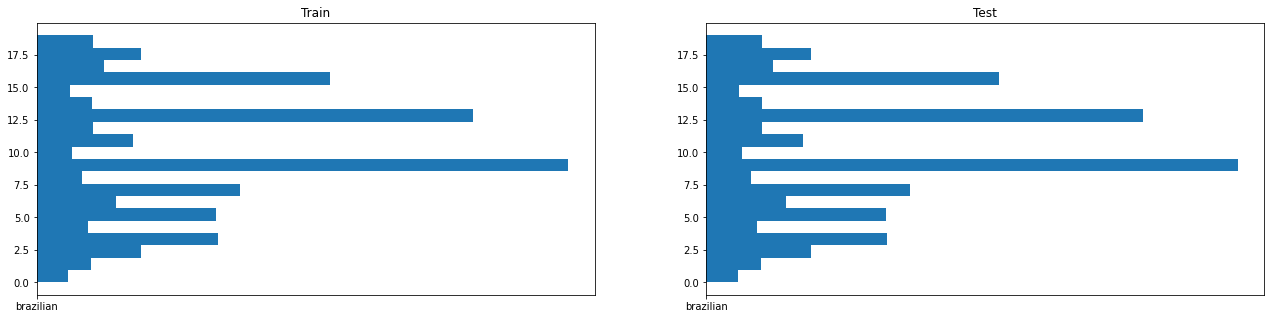

In [31]:
fig, ax = plt.subplots(1, 2,figsize=(22,5))

ax[0].hist(y_train.sort_values(),orientation='horizontal', bins=20, density=True)
ax[1].hist(y_test.sort_values(),orientation='horizontal', bins=20, density=True)
ax[0].set_title('Train')
ax[1].set_title('Test')
fig.show()

In [33]:

lr = LogisticRegression().fit(x_train, y_train)
print(classification_report(y_test, lr.predict(x_test)))


              precision    recall  f1-score   support

   brazilian       0.49      0.27      0.35       117
     british       0.36      0.17      0.23       201
cajun_creole       0.72      0.59      0.65       386
     chinese       0.71      0.78      0.74       668
    filipino       0.60      0.44      0.51       189
      french       0.47      0.46      0.47       662
       greek       0.61      0.41      0.49       294
      indian       0.79      0.78      0.78       751
       irish       0.51      0.31      0.38       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.65      0.44      0.53       131
    japanese       0.51      0.43      0.47       356
      korean       0.74      0.66      0.70       207
     mexican       0.84      0.86      0.85      1610
    moroccan       0.70      0.65      0.68       205
     russian       0.53      0.29      0.37       122
 southern_us       0.48      0.63      0.55      1080
     spanish       0.46    

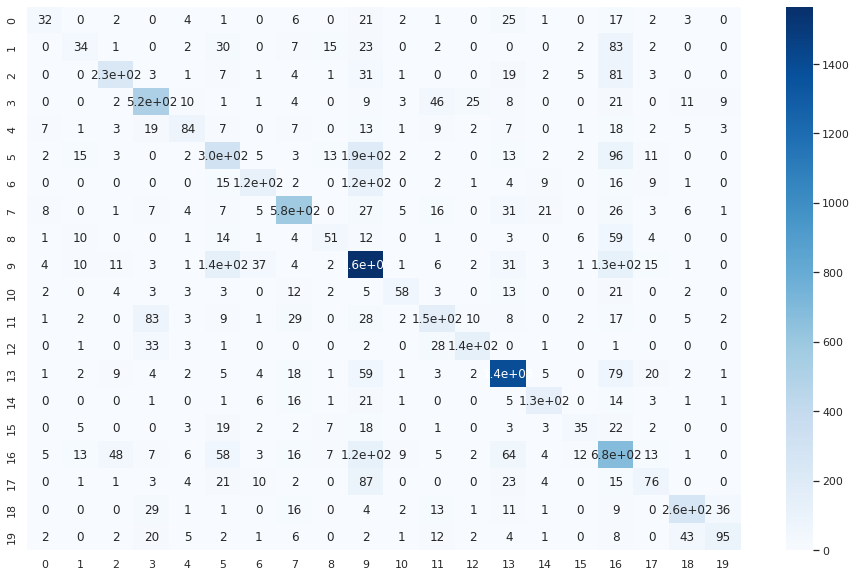

In [34]:
conf_mat = confusion_matrix(y_test, lr.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

In [35]:
# TAKES A WHILE

lr_cv = LogisticRegressionCV(cv=5).fit(x_train, y_train)

In [36]:
print(classification_report(y_test, lr_cv.predict(x_test)))

              precision    recall  f1-score   support

   brazilian       0.57      0.26      0.36       117
     british       0.36      0.16      0.22       201
cajun_creole       0.73      0.59      0.65       386
     chinese       0.71      0.78      0.74       668
    filipino       0.63      0.43      0.51       189
      french       0.47      0.47      0.47       662
       greek       0.61      0.40      0.49       294
      indian       0.79      0.78      0.79       751
       irish       0.54      0.31      0.39       167
     italian       0.67      0.80      0.73      1960
    jamaican       0.70      0.44      0.54       131
    japanese       0.51      0.44      0.47       356
      korean       0.77      0.68      0.72       207
     mexican       0.84      0.87      0.85      1610
    moroccan       0.71      0.63      0.67       205
     russian       0.57      0.28      0.37       122
 southern_us       0.48      0.64      0.55      1080
     spanish       0.46    

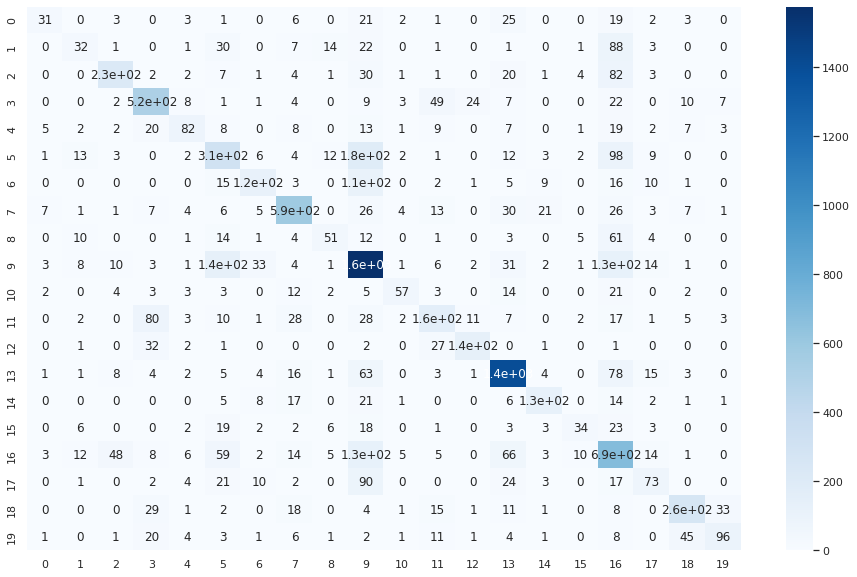

In [37]:
conf_mat = confusion_matrix(y_test, lr_cv.predict(x_test))
sns.set(rc = {'figure.figsize':(16,10)})
sns.heatmap(conf_mat, annot=True, cmap="Blues")

Ref:-https://courses.cognitiveclass.ai/courses/course-v1:IBM+GPXX04XREN+v1/courseware/guided_project/guided_project/1?activate_block_id=block-v1%3AIBM%2BGPXX04XREN%2Bv1%2Btype%40lti_consumer%2Bblock%40launch_skills_network_labs